<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/sparse_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fit an MLP using an L1 penalty on the weights to make a sparse network

We use projected gradient descent as the optimizer

In [1]:
!git clone https://github.com/probml/pyprobml /pyprobml &> /dev/null
%cd -q /pyprobml/scripts
import pyprobml_utils as pml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr

import jax.numpy as jnp
from jax import jit, grad, random
from jax.experimental import stax
from jax.experimental.stax import Dense, Softplus
from jax.tree_util import (tree_flatten, tree_unflatten)
from jax.flatten_util import ravel_pytree

from graphviz import Digraph

def generate_data(num_instances, num_vars, key):
  subkeys = random.split(key, 4)
  X = 10 *  random.uniform(subkeys[0], shape=(num_instances, num_vars)) - 5
  var = 0.1
  n_points = 20
  example_points = 10 * random.uniform(subkeys[1], shape=(n_points, num_vars))-5
  targets = 10* random.uniform(subkeys[2], shape=(n_points, 1)) -5
  y = np.zeros((num_instances,1))
  for i in range(num_instances):
      dists = np.sum(np.abs(np.tile(X[i,:],(n_points,1)) - example_points), axis=1)
      lik = (1/np.sqrt(2* np.pi)) * np.exp(-dists/(2*var))
      lik = lik / np.sum(lik)
      y[i,0] = lik.T @ targets + random.normal(subkeys[3])/15
  return X, y

@jit
def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return jnp.sum((preds - targets)**2) / 2.0

def data_stream(num_instances, batch_size):
  rng = npr.RandomState(0)
  num_batches = num_instances // batch_size
  while True:
    perm = rng.permutation(num_instances)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield X[batch_idx], y[batch_idx]

def pgd(alpha, lambd):
  step_size = alpha

  def init(w0):
    return w0

  def soft_thresholding(z, threshold):
    return jnp.sign(z) * jnp.maximum(jnp.absolute(z) -  threshold , 0.0)

  def update(i, g, w):
    g_flat, unflatten = ravel_pytree(g)
    w_flat = ravel_pytree_jit(w)
    updated_params = soft_thresholding(w_flat - step_size * g_flat, step_size * lambd)
    return unflatten(updated_params)

  def get_params(w):
    return w

  def  set_step_size(lr):
    step_size = lr

  return init, update, get_params, soft_thresholding, set_step_size

ravel_pytree_jit = jit(lambda tree: ravel_pytree(tree)[0])

@jit
def line_search(w, g, batch, beta):
  lr_i = 1
  g_flat, unflatten_g = ravel_pytree(g)
  w_flat = ravel_pytree_jit(w)
  z_flat = soft_thresholding(w_flat - lr_i*g_flat, lr_i* lambd)
  z = unflatten_g(z_flat)
  for i in range(20):
    is_converged = loss(z, batch) > loss(w, batch) + g_flat@(z_flat - w_flat) + np.sum((z_flat - w_flat)**2)/(2*lr_i)
    lr_i = jnp.where(is_converged,lr_i, beta*lr_i)
  return lr_i

@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(loss)(params, batch)
  lr_i = line_search(params, g, batch, 0.5)
  set_step_size(lr_i)
  return opt_update(i,g, opt_state)

key = random.PRNGKey(3)
num_epochs = 60000
num_instances, num_vars  = 200, 2
batch_size = num_instances
minim, maxim = -5, 5

x, y = generate_data(num_instances, 1, key)
X = np.c_[np.ones_like(x), x]
batches = data_stream(num_instances, batch_size)

init_random_params, predict = stax.serial(
    Dense(5), Softplus,
    Dense(5), Softplus,
    Dense(5), Softplus,
    Dense(5), Softplus,
    Dense(1))

lambd, step_size = 0.6, 1e-4
opt_init, opt_update, get_params, soft_thresholding, set_step_size =  pgd(step_size,lambd)
_, init_params = init_random_params(key, (-1, num_vars))
opt_state = opt_init(init_params)
itercount = itertools.count()

for epoch in range(num_epochs):
  opt_state = update(next(itercount), opt_state, next(batches))


params = get_params(opt_state)
weights, _ = tree_flatten(params)
w = weights[::2]
print(w)

[DeviceArray([[-0.        , -0.        ,  2.431252  , -0.8119889 ,
              -0.42788023],
             [-0.        , -0.        , -0.65971917, -2.28203   ,
               1.7317362 ]], dtype=float32), DeviceArray([[-0.0000000e+00,  0.0000000e+00,  1.4137154e-04,
              -0.0000000e+00, -0.0000000e+00],
             [-0.0000000e+00,  0.0000000e+00,  1.4137154e-04,
              -0.0000000e+00, -0.0000000e+00],
             [ 6.0303992e-01, -6.7666084e-01,  2.6858740e+00,
               9.9923909e-01,  6.7409021e-01],
             [-4.1243622e-01, -1.3668306e-01, -2.6994646e+00,
              -5.4342234e-01,  8.0237490e-01],
             [-1.3856529e-01,  1.3904269e+00, -1.5361136e+00,
              -1.5628791e-01, -2.6216986e+00]], dtype=float32), DeviceArray([[-0.01175803, -0.        ,  0.        ,  0.00575209,
               0.9268445 ],
             [-2.6765873 , -0.        ,  0.00455653,  0.626099  ,
              -0.5545154 ],
             [ 1.0652171 , -0.        , -0. 

saving image to ../figures/sparse_mlp_fit.pdf


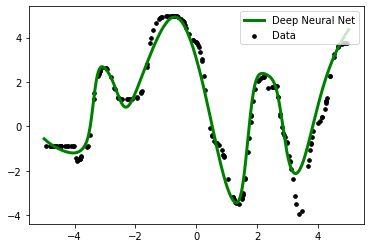

In [8]:
labels = {"training" : "Data", "test" : "Deep Neural Net" }
x_test = np.arange(minim, maxim, 1e-5)
x_test = np.c_[np.ones((x_test.shape[0],1)), x_test]


plt.scatter(X[:,1], y, c='k', s=13, label=labels["training"])
plt.plot(x_test[:,1], predict(params, x_test), 'g-',linewidth=3, label=labels["test"])
plt.gca().legend(loc="upper right")
pml.savefig('sparse_mlp_fit.pdf', dpi=300)
plt.show()



In [4]:
dot = Digraph(name='Neural Network',format='png',graph_attr={'ordering':'out'}, node_attr={'shape': 'circle', 'color': 'black', 'fillcolor':'#FFFFE0', 'style': 'filled'})

dot.node('00','<x<SUB>0</SUB>>')
dot.node('01','<x<SUB>1</SUB>>')
for i in range(len(w)):
  for j in range(w[i].shape[1]):
    subscript = '{}{}'.format(i+1, j)
    dot.node(subscript, '<h<SUB>{}</SUB>>'.format(subscript))
    for k in range(w[i].shape[0]):
      origin = '{}{}'.format(i,k)
      if np.abs(w[i][k,j])>1e-4:
        dot.edge(origin, subscript)
      else:
        dot.edge(origin, subscript,style='invis')

dot.edge('42','50', style='invis')
dot.view()

'Neural Network.gv.png'

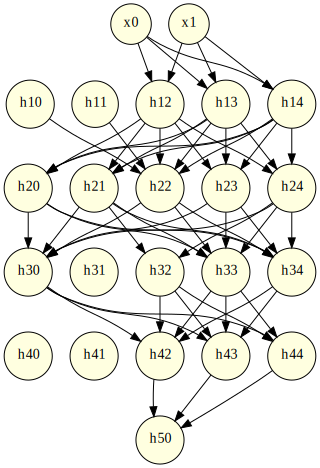

In [5]:
dot

In [9]:
dot.render('../figures/sparse-mlp-graph-structure', view=False)

'../figures/sparse-mlp-graph-structure.png'

In [7]:
!ls ../figures

cat_dog.jpg  sparse-nnet  sparse-nnet.png
